In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

from models import CapsuleNetwork, ReconstructionNetwork

model = CapsuleNetwork()
decoder = ReconstructionNetwork(in_units=10, in_channels=16)

In [18]:
MODEL_PATH = "logs/capsnet_9.pth"
CUDA = False

state_dict = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(state_dict['capsnet'])
decoder.load_state_dict(state_dict['decoder'])

if CUDA:
    model = model.cuda()
    decoder = decoder.cuda()
    
dataset = datasets.MNIST('datasets', train=False, download=True, transform=transforms.ToTensor())

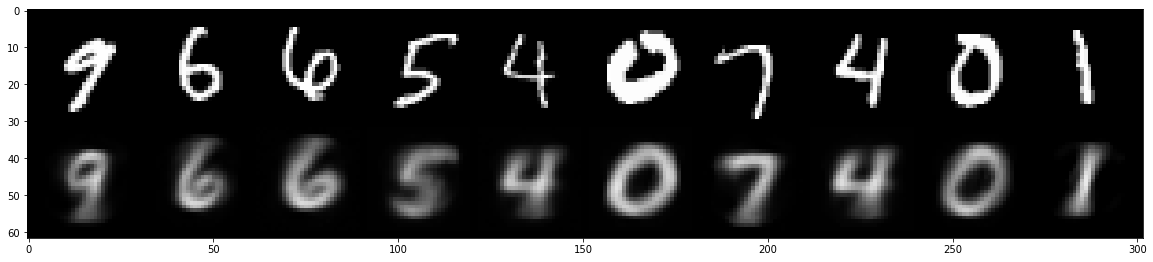

In [19]:
# Generate image from test input

grounds = []
reconss = []
for idx in range(20, 30):
    x, y = dataset[idx]
    with torch.no_grad():
        x = x.unsqueeze(0)
        if CUDA:
            x = x.cuda()
        output = model(x)
        probs = torch.norm(output, p=2, dim=2)
        pred = torch.argmax(probs, dim=1)
        recons = decoder(output, pred)
        
        grounds.append(x)
        reconss.append(recons)


images = torch.cat(grounds + reconss, dim=0)
images = torchvision.utils.make_grid(images, nrow=len(grounds))
images = images.permute(1, 2, 0).contiguous().cpu().data.numpy()
plt.imshow(images)

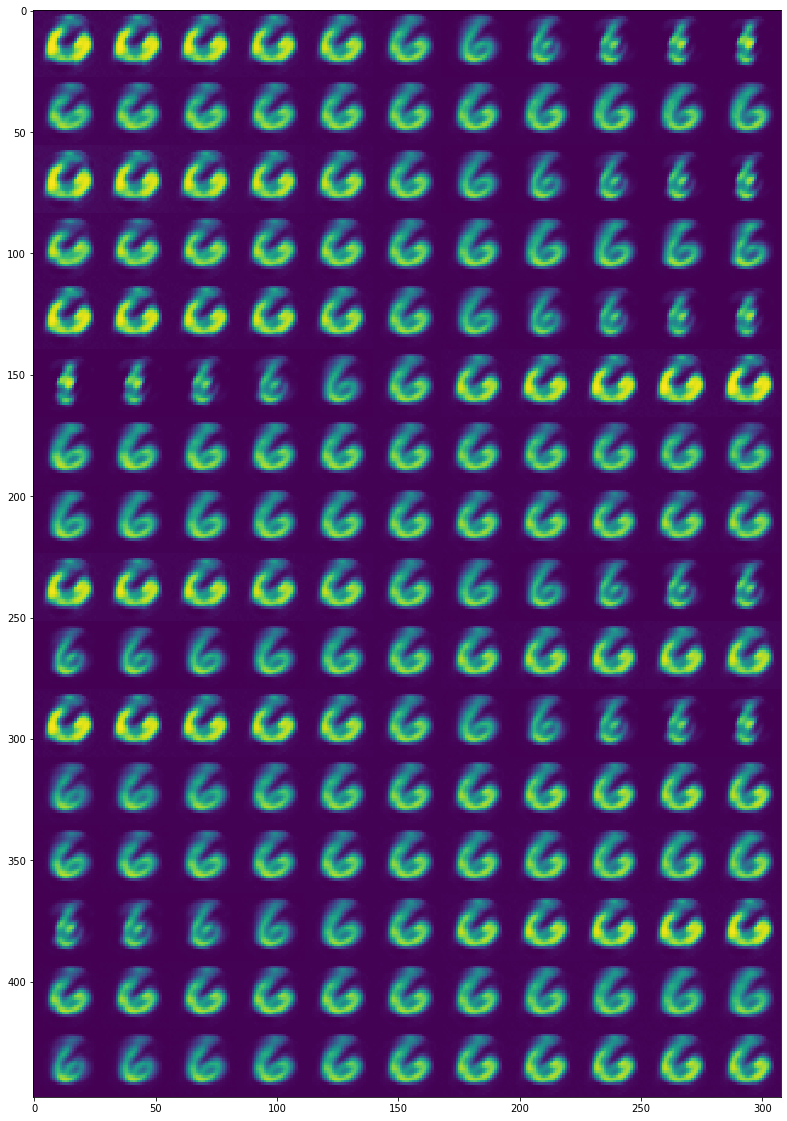

In [25]:
# Perturb a specific image

IDX = 201
x, y = dataset[IDX]

x = x.unsqueeze(0)
if CUDA:
    x = x.cuda()

final_res = []
for each_central_idx in range(16):

    ress = []
    for idx in range(11):
        with torch.no_grad():
            output = model(x)
            probs = torch.norm(output, p=2, dim=2)
            pred = torch.argmax(probs, dim=1)
            recons = decoder(output, pred)

            perturb = output.detach()
            target = pred.item()

            each_central = perturb[0, target, each_central_idx]
            each_central_min = each_central - 0.5
            value = each_central_min + idx * 0.1
            perturb[0, target, each_central_idx] = value

            res = decoder(perturb, pred)
            ress.append(res.squeeze().cpu().data.numpy())

    final_res.append(np.hstack(ress))

plt.imshow(np.vstack(final_res))

In [13]:
image = np.vstack(final_res)